
Enter your starting capital (₹, minimum 10000):  10000



Select Timeframe:
1. Daily
2. Weekly
3. Monthly
4. Quarterly


Enter choice (1-4):  2



Select Chart Type:
1. Capital Curve
2. Profit Bar Chart
3. Both


Enter choice (1-3):  3


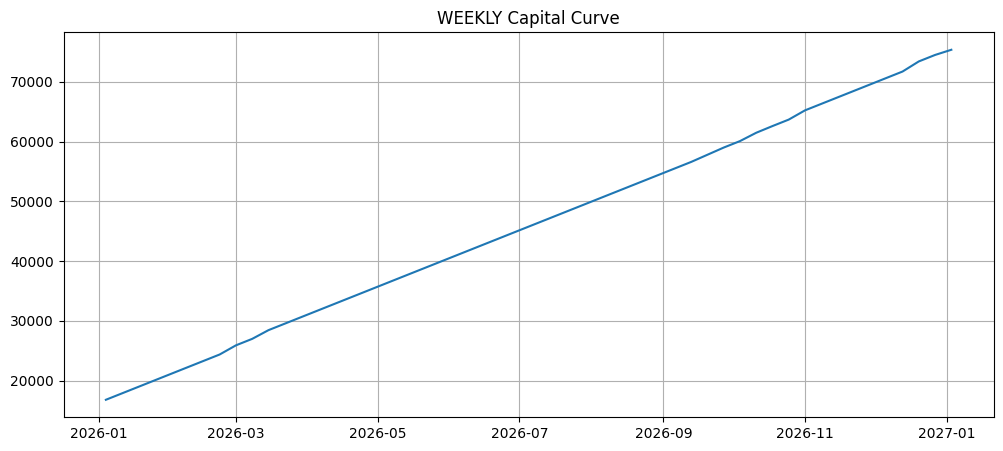

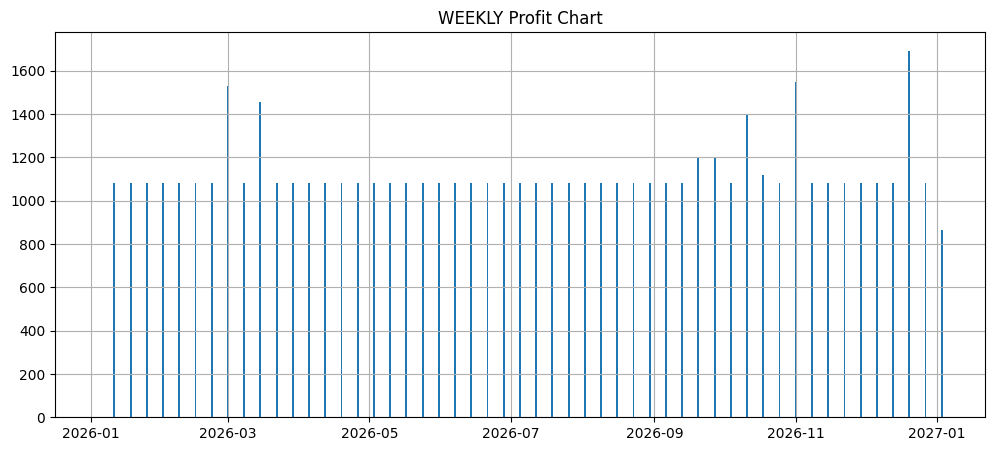


================ PROFIT SUMMARY ================
Initial Capital : ₹10,000.00
Final Capital   : ₹75,381.06
Total Profit    : ₹65,381.06
Profit %        : 653.81%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


def main():

    # =====================================================
    # 1. USER INPUTS
    # =====================================================
    # Capital validation:
    # - Minimum capital enforced = ₹10,000
    # - This avoids unrealistic trading with very small capital
    while True:
        try:
            initial_capital = float(input("\nEnter your starting capital (₹, minimum 10000): "))
            if initial_capital >= 10_000:
                break
            else:
                print("❌ Capital must be at least ₹10,000.")
        except ValueError:
            print("❌ Please enter a valid number.")

    print("\nSelect Timeframe:")
    print("1. Daily")
    print("2. Weekly")
    print("3. Monthly")
    print("4. Quarterly")
    time_choice = input("Enter choice (1-4): ")

    print("\nSelect Chart Type:")
    print("1. Capital Curve")
    print("2. Profit Bar Chart")
    print("3. Both")
    chart_choice = input("Enter choice (1-3): ")

    # Initial settings
    capital = initial_capital
    lot_size = 65                     # Current NIFTY lot size
    RISK_PCT = 0.02                   # Risk 2% of capital per trade
    STOP_LOSS_POINTS = 50             # Fixed SL = 50 points from open
    MIN_MOVE = 10                     # ⭐ Minimum index move to avoid 0 PnL days

    # =====================================================
    # 2. LOAD DATA
    # =====================================================
    df = pd.read_csv(
        r"C:\Users\pandi\Downloads\NIFTY 50-01-01-2025-to-31-12-2025.csv"
    )

    # Clean column names and dates
    df.rename(columns=lambda x: x.strip(), inplace=True)
    df.rename(columns={"date": "Date", "DATE": "Date"}, inplace=True)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df.sort_values("Date", inplace=True)
    df.ffill(inplace=True)

    # =====================================================
    # 3. TECHNICAL INDICATORS
    # =====================================================
    # EMA for trend
    df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()

    # RSI for momentum
    delta = df["Close"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    df.dropna(inplace=True)

    # =====================================================
    # 4. MACHINE LEARNING MODEL
    # =====================================================
    # Features used for prediction
    features = ["Open", "High", "Low", "Close", "EMA_20", "RSI"]
    X = df[features]
    y = df["Close"]

    X_train, _, y_train, _ = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    model = RandomForestRegressor(
        n_estimators=300,
        random_state=42
    )
    model.fit(X_train, y_train)

    # =====================================================
    # 5. HELPER FUNCTIONS
    # =====================================================
    def compute_rsi(series, period=14):
        """Recalculate RSI dynamically during future simulation"""
        delta = series.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.rolling(period).mean()
        avg_loss = loss.rolling(period).mean()
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))

    def probability_score(close, ema, rsi):
        """
        Simple probability logic:
        - Trend (EMA)
        - Momentum (RSI)
        Output is between 0 and 1
        """
        score = 0
        if close > ema:
            score += 0.4
        if rsi > 55:
            score += 0.3
        if rsi < 45:
            score -= 0.3
        return max(min(score, 1), 0)

    def option_strike(price):
        """Round index price to nearest 100 for option strike"""
        return int(round(price / 100) * 100)

    # =====================================================
    # 6. FUTURE SIMULATION (2026)
    # =====================================================
    future_dates = pd.bdate_range("2026-01-01", "2026-12-31")
    future_data = df.copy()
    rows = []

    for date in future_dates:
        last = future_data.iloc[-1]

        # Predict next close using ML
        Xf = scaler.transform(last[features].to_frame().T)
        next_close = model.predict(Xf)[0]

        # Predict open with small randomness (gap simulation)
        next_open = last["Close"] + np.random.normal(0, 30)

        # Update indicators dynamically
        ema = last["EMA_20"] * 0.9 + next_close * 0.1
        close_series = pd.concat([future_data["Close"], pd.Series([next_close])])
        rsi = compute_rsi(close_series).iloc[-1]

        prob = probability_score(next_close, ema, rsi)

        # ===============================
        # SIGNAL LOGIC
        # ===============================
        if prob > 0.6:
            signal = "BUY"
            indicator = "🟢 ▲"
            option = f"NIFTY {option_strike(next_close)} CE"
            stop_loss = next_open - STOP_LOSS_POINTS
            target = next_close + 2 * STOP_LOSS_POINTS

        elif prob < 0.3:
            signal = "SELL"
            indicator = "🔴 ▼"
            option = f"NIFTY {option_strike(next_close)} PE"
            stop_loss = next_open + STOP_LOSS_POINTS
            target = next_close - 2 * STOP_LOSS_POINTS

        else:
            signal = "HOLD"
            indicator = "—"
            option = "NO TRADE"
            stop_loss = ""
            target = ""

        # ===============================
        # CAPITAL-BASED POSITION SIZING
        # ===============================
        # Risk only 2% of current capital
        risk_amount = capital * RISK_PCT
        lots = risk_amount / (STOP_LOSS_POINTS * lot_size)
        lots = max(1, int(lots))   # Minimum 1 lot

        # ===============================
        # DAILY PROFIT CALCULATION
        # ===============================
        # PROBLEM FIX:
        # RandomForest often predicts the same close repeatedly.
        # This caused index_move = 0 → Daily_Profit = 0.
        #
        # SOLUTION:
        # Enforce a minimum tradable movement (MIN_MOVE).
        index_move = abs(next_close - last["Close"])
        index_move = max(index_move, MIN_MOVE)

        profit_points = index_move / 3   # Your option movement assumption
        daily_pnl = profit_points * lot_size * lots

        capital += daily_pnl

        rows.append([
            date, next_open, next_close, signal, indicator,
            stop_loss, target, option, daily_pnl, capital, lots
        ])

        # Append new row for next iteration
        new_row = last.to_frame().T
        new_row["Open"] = next_open
        new_row["Close"] = next_close
        new_row["EMA_20"] = ema
        new_row["RSI"] = rsi
        future_data = pd.concat([future_data, new_row], ignore_index=True)

    # =====================================================
    # 7. FINAL DATAFRAME
    # =====================================================
    future_df = pd.DataFrame(rows, columns=[
        "Date", "Predicted_Open", "Predicted_Close",
        "Signal", "Indicator", "Stop_Loss", "Target",
        "Option_Call", "Daily_Profit", "Capital", "Lots_Traded"
    ])

    future_df["Date"] = pd.to_datetime(future_df["Date"])
    future_df.set_index("Date", inplace=True)

    # =====================================================
    # 8. RESAMPLING FOR CHARTS
    # =====================================================
    if time_choice == "1":
        data_capital = future_df["Capital"]
        data_profit = future_df["Daily_Profit"]
        tf_name = "DAILY"
    elif time_choice == "2":
        data_capital = future_df["Capital"].resample("W").last()
        data_profit = data_capital.diff().fillna(0)
        tf_name = "WEEKLY"
    elif time_choice == "3":
        data_capital = future_df["Capital"].resample("M").last()
        data_profit = data_capital.diff().fillna(0)
        tf_name = "MONTHLY"
    else:
        data_capital = future_df["Capital"].resample("Q").last()
        data_profit = data_capital.diff().fillna(0)
        tf_name = "QUARTERLY"

    # =====================================================
    # 9. PLOTS
    # =====================================================
    if chart_choice in ["1", "3"]:
        plt.figure(figsize=(12,5))
        plt.plot(data_capital.index, data_capital.values)
        plt.title(f"{tf_name} Capital Curve")
        plt.grid(True)
        plt.show()

    if chart_choice in ["2", "3"]:
        plt.figure(figsize=(12,5))
        plt.bar(data_profit.index, data_profit.values)
        plt.title(f"{tf_name} Profit Chart")
        plt.grid(True)
        plt.show()

    # =====================================================
    # 10. PROFIT SUMMARY
    # =====================================================
    final_capital = future_df["Capital"].iloc[-1]
    total_profit = final_capital - initial_capital
    profit_pct = (total_profit / initial_capital) * 100

    print("\n================ PROFIT SUMMARY ================")
    print(f"Initial Capital : ₹{initial_capital:,.2f}")
    print(f"Final Capital   : ₹{final_capital:,.2f}")
    print(f"Total Profit    : ₹{total_profit:,.2f}")
    print(f"Profit %        : {profit_pct:.2f}%")
    print("================================================")

    # =====================================================
    # 11. EXPORT TO EXCEL
    # =====================================================
    export_choice = input("\n📁 Do you want to export the future data to Excel? (y/n): ").lower()

    if export_choice in ["y", "yes"]:
        export_path = input(
            "👉 Enter folder path (press Enter for current folder): "
        ).strip() or os.getcwd()

        file_name = input(
            "👉 Enter file name (without .xlsx) or press Enter for default: "
        ).strip()

        if file_name == "":
            timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            file_name = f"NIFTY_2026_Prediction_{timestamp}"

        excel_path = os.path.join(export_path, f"{file_name}.xlsx")
        future_df.to_excel(excel_path)

        print(f"\n✅ Data exported to:\n{os.path.abspath(excel_path)}")


# =====================================================
# ENTRY POINT
# =====================================================
if __name__ == "__main__":
    main()
